**1st attempt**

Found 22 July folders.
Total sequences: 95 | Train: 78 | Val: 17


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, 3, 256, 256,    │        10,432 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 256, 256,    │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, 256, 256, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 1)    │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,481 (68.29 KB)

 Trainable params: 17,433 (68.10 KB)

 Non-trainable params: 48 (192.00 B)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6621 - loss: 0.8294 - val_accuracy: 0.8164 - val_loss: 0.6758
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7448 - loss: 0.6868 - val_accuracy: 0.8148 - val_loss: 0.6600
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7770 - loss: 0.6400 - val_accuracy: 0.8148 - val_loss: 0.6460
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7805 - loss: 0.6179 - val_accuracy: 0.8148 - val_loss: 0.6318
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7921 - loss: 0.6040 - val_accuracy: 0.8148 - val_loss: 0.6155
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8087 - loss: 0.5799 - val_accuracy: 0.8148 - val_loss: 0.5989
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8301 - loss: 0.5597 - val_accuracy: 0.8148 - val_loss: 0.5827
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8469 - loss: 0.5363 - val_accuracy: 0.8148 - val_loss:

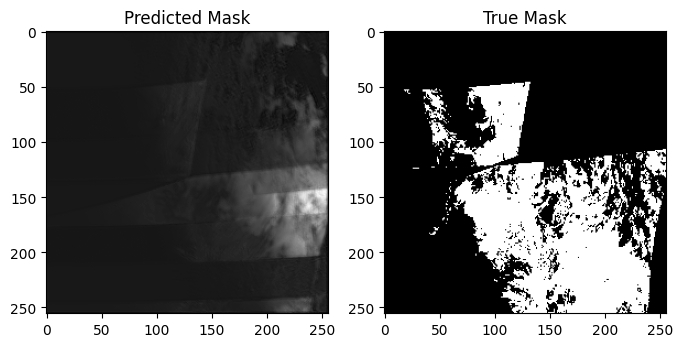

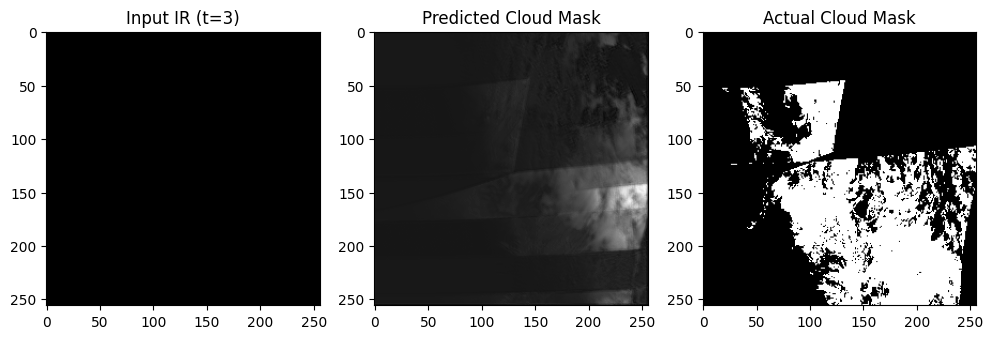

CSI: 0.0


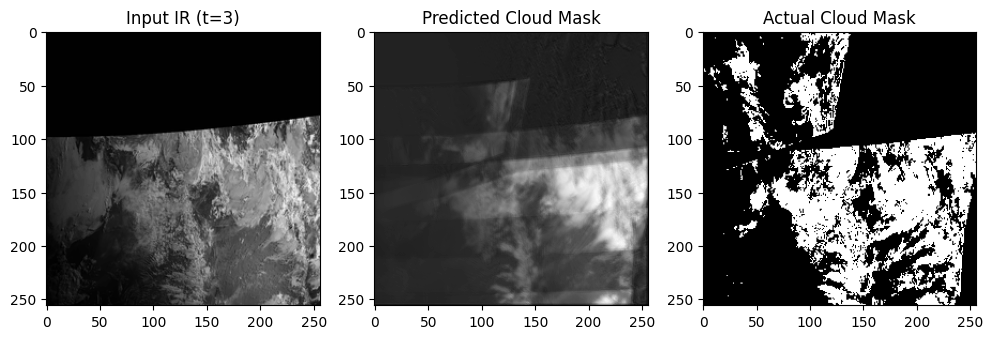

CSI: 0.0


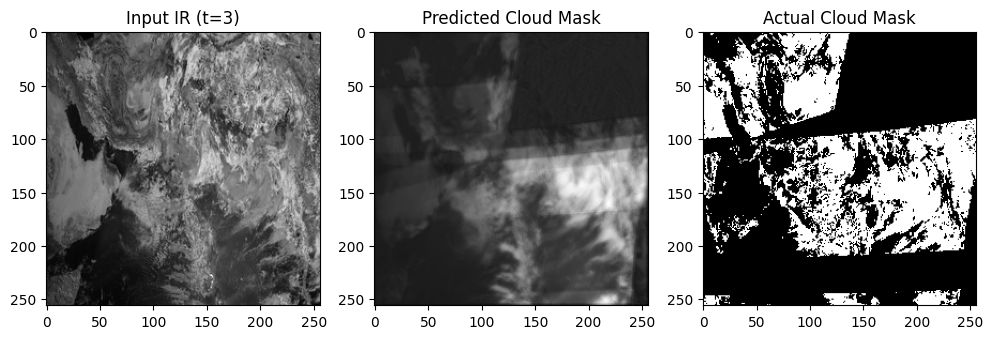

CSI: 0.0


In [5]:
"""
Cloud Forecasting Pipeline (EUMETSAT, TensorFlow, July, 3hr→1hr)

This script builds and trains a cloud prediction model using all available EUMETSAT satellite data (IR and VIS channels) from the month of July.

Steps:
1. Imports & Setup
2. Data Loading & Sequence Extraction (all July days)
3. Cloud Mask Generation
4. Dataset Construction (train/val split)
5. Model Definition (ConvLSTM)
6. Training
7. Evaluation & Visualization
8. Export for Web Visualization
"""

# 1. Imports & Setup
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import urllib.parse

# 2. Data Loading & Sequence Extraction

def get_july_folders(base_dir='downloaded_images'):
    # Find all folders for July (format: YYYY-MM-DD)
    folders = sorted([os.path.join(base_dir, d) for d in os.listdir(base_dir)
                     if os.path.isdir(os.path.join(base_dir, d)) and '-07-' in d])
    return folders

def extract_hour_from_filename(filename):
    # Decode URL-encoded characters
    decoded = urllib.parse.unquote(os.path.basename(filename))
    # Match pattern like [07-00] or [14-00]
    match = re.search(r'\[(\d{2})-\d{2}\]', decoded)
    if match:
        return int(match.group(1))
    return None

# Update list_hour_files to only include files with a valid hour

def list_hour_files(day_dir, channel_prefix):
    files = sorted(glob.glob(os.path.join(day_dir, f'{channel_prefix}*[*-00]*.webp')))
    # Also include .bmp files
    files += sorted(glob.glob(os.path.join(day_dir, f'{channel_prefix}*[*-00]*.bmp')))
    # Only keep files with a valid hour
    files = [f for f in files if extract_hour_from_filename(f) is not None]
    return files

# Update extract_sequences_from_day to use the new hour extraction

def extract_sequences_from_day(day_dir):
    ir_files = list_hour_files(day_dir, 'IR_016_IO_region_reprojected_WG')
    vis_files = list_hour_files(day_dir, 'HRV_IO_region_WG')
    # Build a dict: hour -> file
    ir_dict = {extract_hour_from_filename(f): f for f in ir_files}
    vis_dict = {extract_hour_from_filename(f): f for f in vis_files}
    hours = sorted(list(set(ir_dict.keys()) & set(vis_dict.keys())))
    sequences = []
    for i in range(len(hours) - 3):
        in_hours = hours[i:i+3]
        out_hour = hours[i+3]
        try:
            ir_in = [ir_dict[h] for h in in_hours]
            vis_in = [vis_dict[h] for h in in_hours]
            ir_out = ir_dict[out_hour]
            vis_out = vis_dict[out_hour]
            sequences.append({
                'ir_in': ir_in,
                'vis_in': vis_in,
                'ir_out': ir_out,
                'vis_out': vis_out,
                'date': os.path.basename(day_dir),
                'in_hours': in_hours,
                'out_hour': out_hour
            })
        except KeyError:
            continue  # skip incomplete sequences
    return sequences

def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-6)

DOWNSAMPLED_SIZE = (256, 256)  # (width, height)
BATCH_SIZE = 8  # Increased batch size for faster training if RAM allows

def load_img(path):
    img = Image.open(path).convert('L')
    img = img.resize(DOWNSAMPLED_SIZE, resample=Image.LANCZOS)  # High-quality downsampling
    return normalize(np.array(img))

# 3. Cloud Mask Generation

def cloud_mask(ir_img, vis_img, ir_thresh=0.6, vis_thresh=0.3):
    ir_mask = ir_img < ir_thresh
    vis_mask = vis_img > vis_thresh
    return ir_mask & vis_mask

# 4. Dataset Construction

def build_dataset(july_folders, val_days=3):
    all_sequences = []
    for day_dir in july_folders:
        all_sequences.extend(extract_sequences_from_day(day_dir))
    # Split by date for validation
    all_dates = sorted(list(set(seq['date'] for seq in all_sequences)))
    train_dates = all_dates[:-val_days]
    val_dates = all_dates[-val_days:]
    train_seqs = [seq for seq in all_sequences if seq['date'] in train_dates]
    val_seqs = [seq for seq in all_sequences if seq['date'] in val_dates]
    print(f"Total sequences: {len(all_sequences)} | Train: {len(train_seqs)} | Val: {len(val_seqs)}")
    return train_seqs, val_seqs

def seq_to_arrays(seq):
    # Load and stack 3 IR and 3 VIS images for input, 1 IR and 1 VIS for output
    ir_in = [load_img(f) for f in seq['ir_in']]
    vis_in = [load_img(f) for f in seq['vis_in']]
    ir_out = load_img(seq['ir_out'])
    vis_out = load_img(seq['vis_out'])
    # Stack input: (3, H, W, 2)
    X = np.stack([np.stack([ir, vis], axis=-1) for ir, vis in zip(ir_in, vis_in)], axis=0)
    # Output cloud mask
    y = cloud_mask(ir_out, vis_out).astype(np.float32)[..., np.newaxis]
    return X, y

def make_tf_dataset(sequences, batch_size=BATCH_SIZE, shuffle=True):
    # Generator for tf.data.Dataset
    def gen():
        idxs = list(range(len(sequences)))
        if shuffle:
            random.shuffle(idxs)
        for i in idxs:
            X, y = seq_to_arrays(sequences[i])
            yield X, y
    sample_X, sample_y = seq_to_arrays(sequences[0])
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=sample_X.shape, dtype=tf.float32),
            tf.TensorSpec(shape=sample_y.shape, dtype=tf.float32)
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=32)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# 5. Model Definition (ConvLSTM2D)

def dice_loss(y_true, y_pred):
    # Dice loss for binary segmentation
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def build_convlstm_satellite(input_shape):
    model = keras.Sequential([
        layers.ConvLSTM2D(16, (3,3), activation='relu', input_shape=input_shape, return_sequences=True, padding='same'),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(8, (3,3), activation='relu', return_sequences=False, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(1, (1,1), activation='sigmoid')
    ])
    # To use Dice loss, change 'binary_crossentropy' to dice_loss below:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
    return model

# 6. Training

def train_model(model, train_ds, val_ds, epochs=5):
    # Save the best model based on validation loss
    checkpoint_cb = ModelCheckpoint('cloud_forecast_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_cb])
    print("Best model saved as 'cloud_forecast_best_model.keras'")
    return history

# 7. Evaluation & Visualization

def plot_forecast(ir_img, y_pred, y_true):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(ir_img, cmap='gray')
    plt.title('Input IR (t=3)')
    plt.subplot(1,3,2)
    plt.imshow(y_pred, cmap='gray')
    plt.title('Predicted Cloud Mask')
    plt.subplot(1,3,3)
    plt.imshow(y_true, cmap='gray')
    plt.title('Actual Cloud Mask')
    plt.show()

def csi(y_true, y_pred):
    # Convert to numpy arrays if they are tensors
    if hasattr(y_true, 'numpy'):
        y_true = y_true.numpy()
    if hasattr(y_pred, 'numpy'):
        y_pred = y_pred.numpy()
    y_true = y_true > 0.5
    y_pred = y_pred > 0.5
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fp + fn + 1e-6)

# 8. Export for Web Visualization

def export_forecast(y_pred, filename='forecast_cloud_mask.png'):
    Image.fromarray((y_pred*255).astype(np.uint8)).save(filename)

# =====================
# Main Pipeline Example
# =====================
if __name__ == "__main__":
    # 1. Find all July folders
    july_folders = get_july_folders('downloaded_images')
    print(f"Found {len(july_folders)} July folders.")

    # 2. Build train/val sequence lists
    train_seqs, val_seqs = build_dataset(july_folders, val_days=3)

    # 3. Build tf.data.Dataset objects
    train_ds = make_tf_dataset(train_seqs, batch_size=BATCH_SIZE, shuffle=True)
    val_ds = make_tf_dataset(val_seqs, batch_size=BATCH_SIZE, shuffle=False)

    # 4. Model
    # Use the shape of the first sample for input_shape
    sample_X, _ = seq_to_arrays(train_seqs[0])
    input_shape = sample_X.shape  # (3, H, W, 2)
    model = build_convlstm_satellite(input_shape)
    model.summary()

    # 5. Train
    history = train_model(model, train_ds, val_ds, epochs=30)  # Increased epochs for deeper training

    # 6. Evaluate and visualize on a few validation samples
    for X, y in val_ds.take(1):
        y_pred = model.predict(X)
        # Print stats for debugging
        print('y_pred min:', y_pred.min(), 'max:', y_pred.max(), 'mean:', y_pred.mean())
        y_true_np = y[...,0].numpy() if hasattr(y[...,0], 'numpy') else y[...,0]
        print('y_true min:', y_true_np.min(), 'max:', y_true_np.max(), 'mean:', y_true_np.mean())
        # Visualize first prediction and ground truth
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(y_pred[0,...,0], cmap='gray')
        plt.title('Predicted Mask')
        plt.subplot(1,2,2)
        plt.imshow(y_true_np[0], cmap='gray')
        plt.title('True Mask')
        plt.show()
        for i in range(min(3, X.shape[0])):
            plot_forecast(X[i,-1,:, :,0], y_pred[i,...,0], y[i,...,0])
            print('CSI:', csi(y[i,...,0], y_pred[i,...,0]))

    # 7. Export one forecast
    export_forecast(y_pred[0,...,0]) 

**Changed the csi threshold, increased batch size**

Found 22 July folders.
Total sequences: 95 | Train: 78 | Val: 17


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_10 (ConvLSTM2D)     │ (None, 3, 256, 256,    │        10,432 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 3, 256, 256,    │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, 256, 256, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 1)    │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,481 (68.29 KB)

 Trainable params: 17,433 (68.10 KB)

 Non-trainable params: 48 (192.00 B)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6360 - loss: 0.8187 - val_accuracy: 0.8017 - val_loss: 0.7556
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6885 - loss: 0.6783 - val_accuracy: 0.8200 - val_loss: 0.7559
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6625 - loss: 0.7754 - val_accuracy: 0.8243 - val_loss: 0.7570
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6831 - loss: 0.7416 - val_accuracy: 0.8199 - val_loss: 0.7595
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7054 - loss: 0.7013 - val_accuracy: 0.8164 - val_loss: 0.7636
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7351 - loss: 0.7125 - val_accuracy: 0.8148 - val_loss: 0.7684
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7312 - loss: 0.7377 - val_accuracy: 0.8148 - val_loss: 0.7745
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7391 - loss: 0.6783 - val_accuracy: 0.8148 - val_loss:

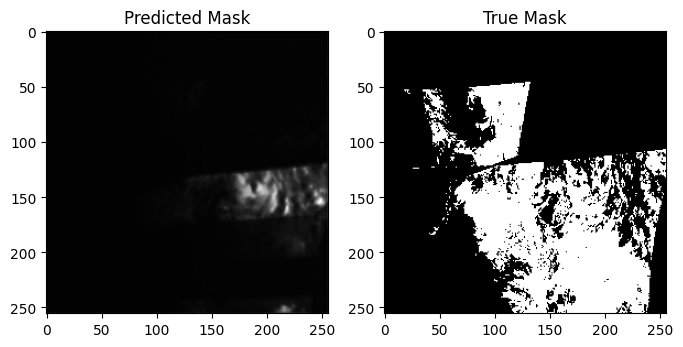

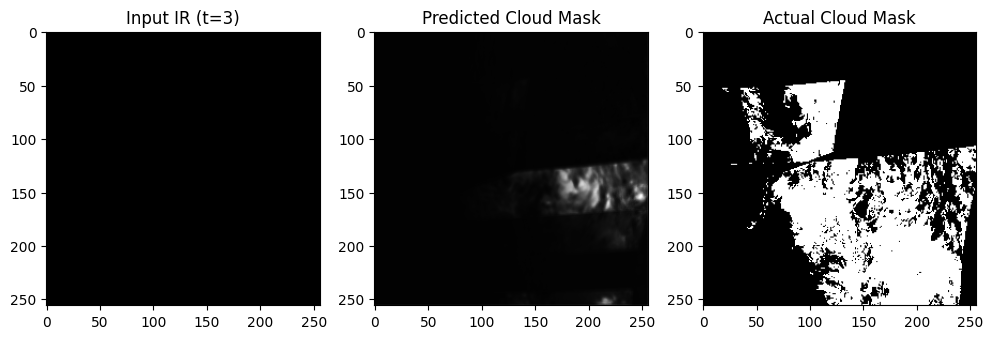

CSI (threshold=0.2): 0.023091470089425126


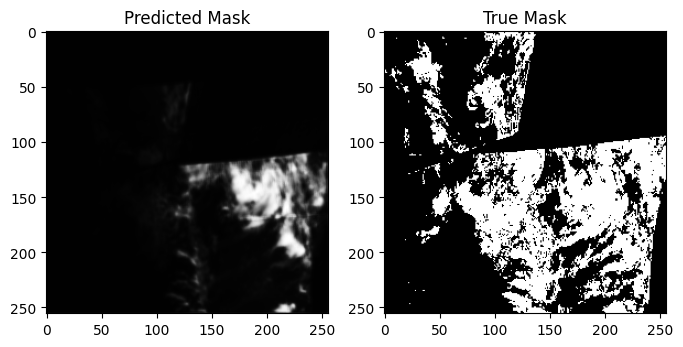

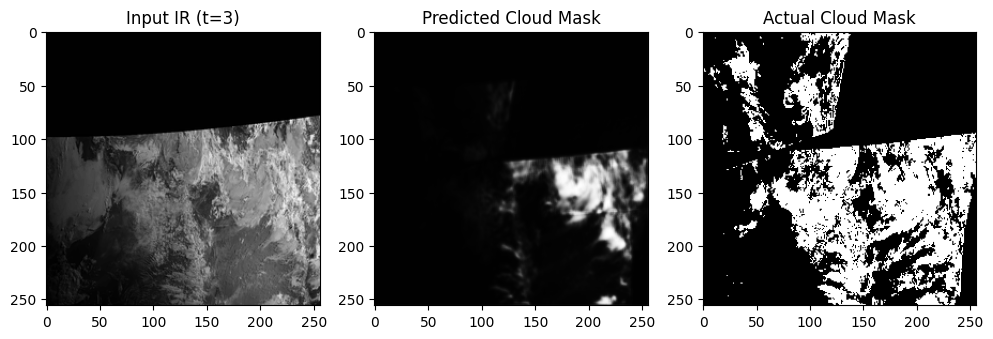

CSI (threshold=0.2): 0.20669243186699807


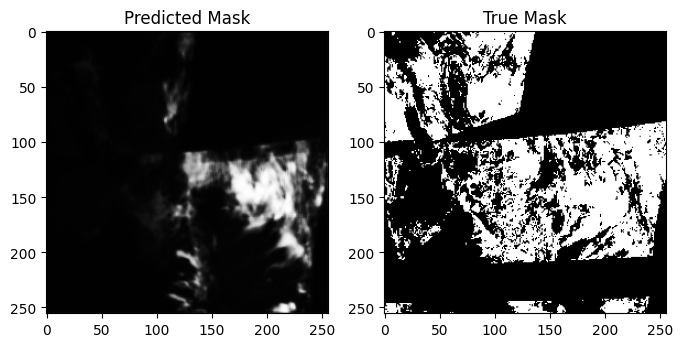

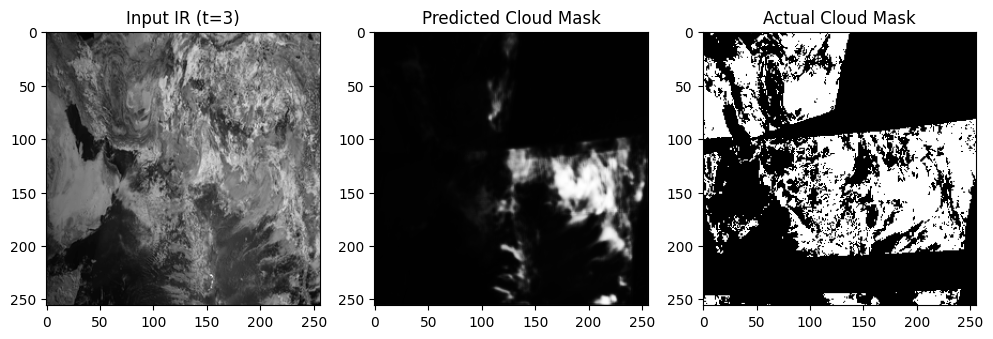

CSI (threshold=0.2): 0.21020442358368782


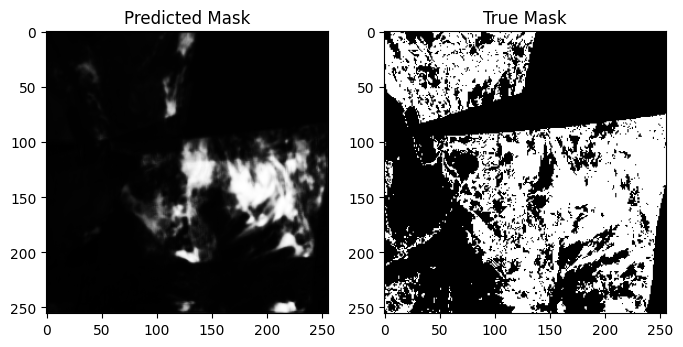

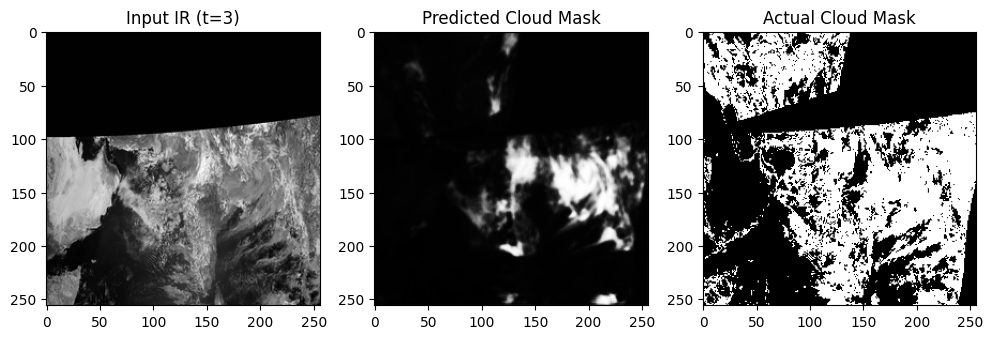

CSI (threshold=0.2): 0.21497508796853854


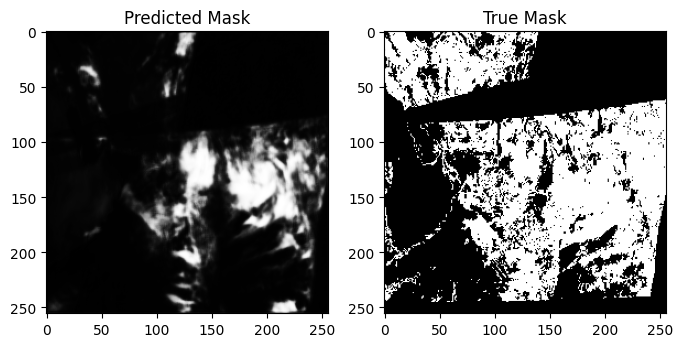

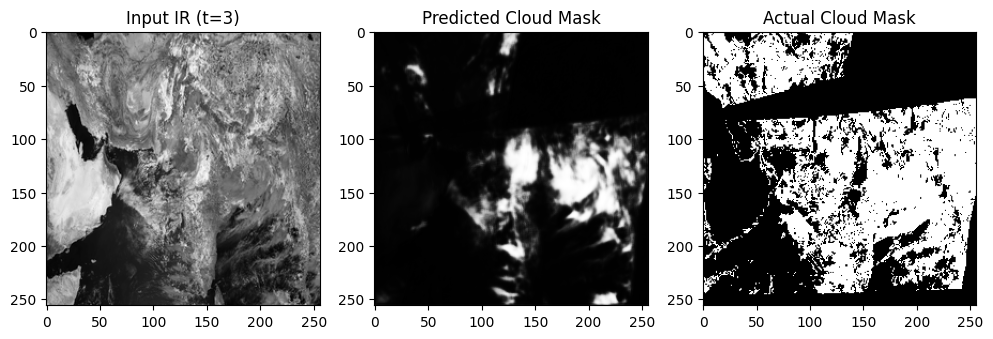

CSI (threshold=0.2): 0.2547049805846667


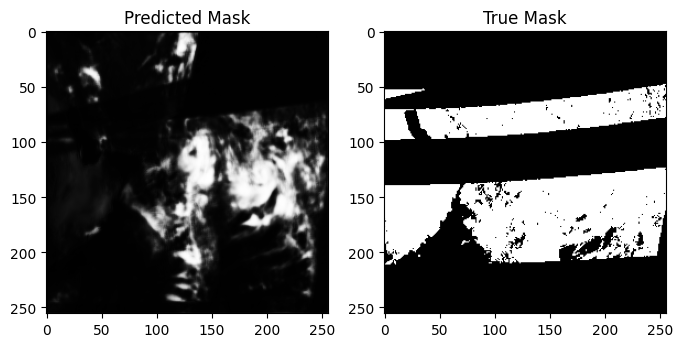

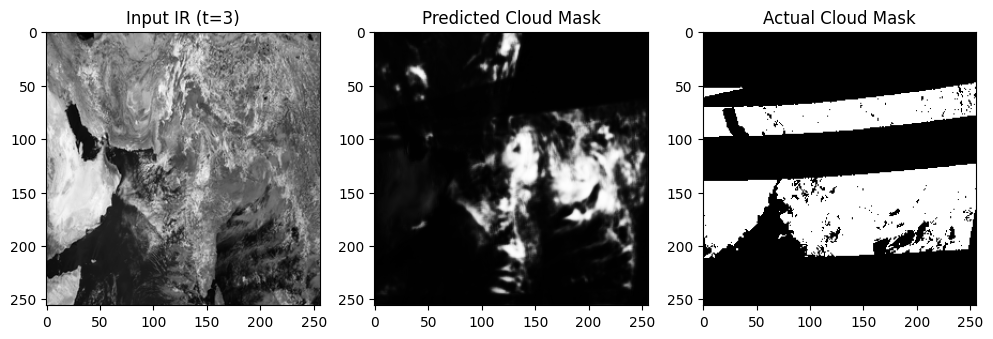

CSI (threshold=0.2): 0.22629780426689333


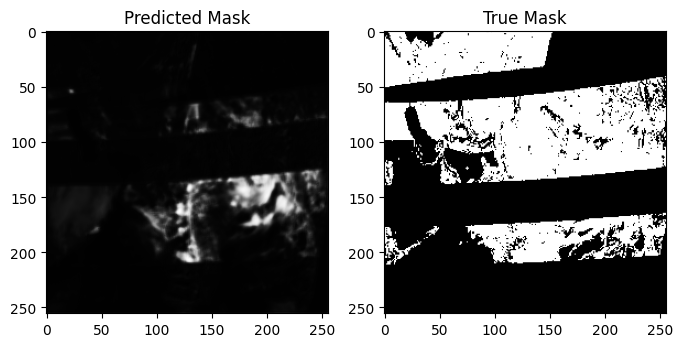

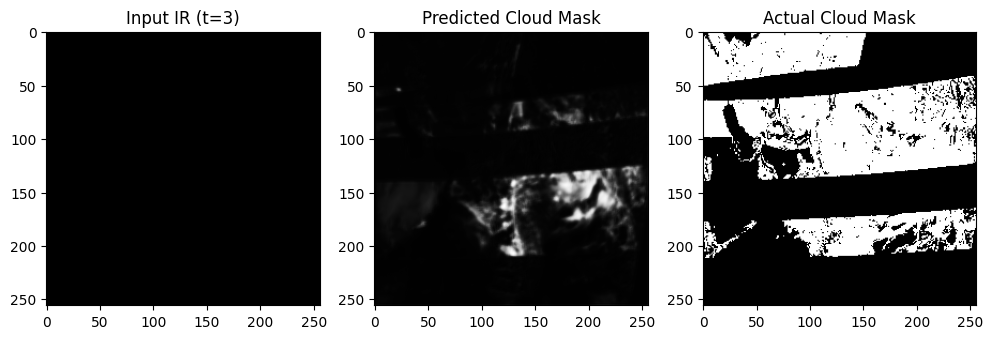

CSI (threshold=0.2): 0.041470744209246214


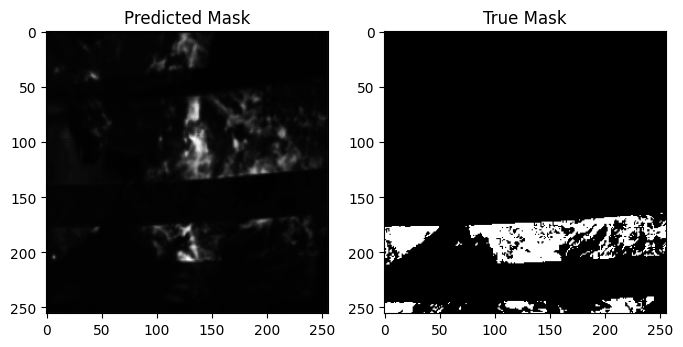

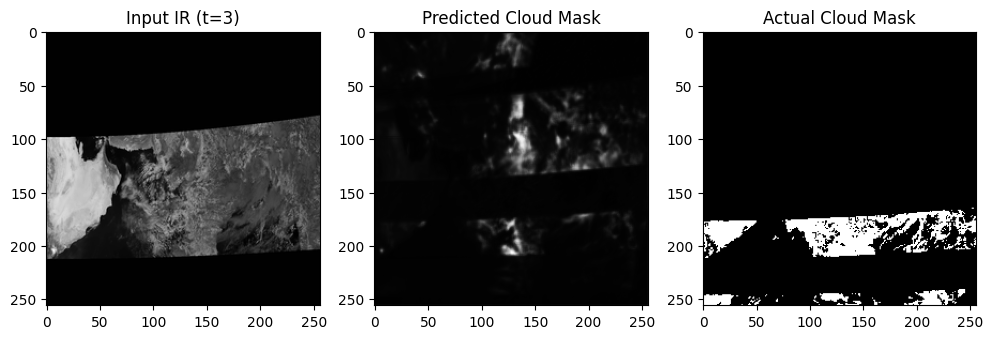

CSI (threshold=0.2): 0.05111775593747433


In [6]:
"""
Cloud Forecasting Pipeline (EUMETSAT, TensorFlow, July, 3hr→1hr)

This script builds and trains a cloud prediction model using all available EUMETSAT satellite data (IR and VIS channels) from the month of July.

Steps:
1. Imports & Setup
2. Data Loading & Sequence Extraction (all July days)
3. Cloud Mask Generation
4. Dataset Construction (train/val split)
5. Model Definition (ConvLSTM)
6. Training
7. Evaluation & Visualization
8. Export for Web Visualization
"""

# 1. Imports & Setup
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import urllib.parse

# 2. Data Loading & Sequence Extraction

def get_july_folders(base_dir='downloaded_images'):
    # Find all folders for July (format: YYYY-MM-DD)
    folders = sorted([os.path.join(base_dir, d) for d in os.listdir(base_dir)
                     if os.path.isdir(os.path.join(base_dir, d)) and '-07-' in d])
    return folders

def extract_hour_from_filename(filename):
    # Decode URL-encoded characters
    decoded = urllib.parse.unquote(os.path.basename(filename))
    # Match pattern like [07-00] or [14-00]
    match = re.search(r'\[(\d{2})-\d{2}\]', decoded)
    if match:
        return int(match.group(1))
    return None

# Update list_hour_files to only include files with a valid hour

def list_hour_files(day_dir, channel_prefix):
    files = sorted(glob.glob(os.path.join(day_dir, f'{channel_prefix}*[*-00]*.webp')))
    # Also include .bmp files
    files += sorted(glob.glob(os.path.join(day_dir, f'{channel_prefix}*[*-00]*.bmp')))
    # Only keep files with a valid hour
    files = [f for f in files if extract_hour_from_filename(f) is not None]
    return files

# Update extract_sequences_from_day to use the new hour extraction

def extract_sequences_from_day(day_dir):
    ir_files = list_hour_files(day_dir, 'IR_016_IO_region_reprojected_WG')
    vis_files = list_hour_files(day_dir, 'HRV_IO_region_WG')
    # Build a dict: hour -> file
    ir_dict = {extract_hour_from_filename(f): f for f in ir_files}
    vis_dict = {extract_hour_from_filename(f): f for f in vis_files}
    hours = sorted(list(set(ir_dict.keys()) & set(vis_dict.keys())))
    sequences = []
    for i in range(len(hours) - 3):
        in_hours = hours[i:i+3]
        out_hour = hours[i+3]
        try:
            ir_in = [ir_dict[h] for h in in_hours]
            vis_in = [vis_dict[h] for h in in_hours]
            ir_out = ir_dict[out_hour]
            vis_out = vis_dict[out_hour]
            sequences.append({
                'ir_in': ir_in,
                'vis_in': vis_in,
                'ir_out': ir_out,
                'vis_out': vis_out,
                'date': os.path.basename(day_dir),
                'in_hours': in_hours,
                'out_hour': out_hour
            })
        except KeyError:
            continue  # skip incomplete sequences
    return sequences

def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-6)

DOWNSAMPLED_SIZE = (256, 256)  # (width, height)
BATCH_SIZE = 8  # Increased batch size for faster training if RAM allows

def load_img(path):
    img = Image.open(path).convert('L')
    img = img.resize(DOWNSAMPLED_SIZE, resample=Image.LANCZOS)  # High-quality downsampling
    return normalize(np.array(img))

# 3. Cloud Mask Generation

def cloud_mask(ir_img, vis_img, ir_thresh=0.6, vis_thresh=0.3):
    ir_mask = ir_img < ir_thresh
    vis_mask = vis_img > vis_thresh
    return ir_mask & vis_mask

# 4. Dataset Construction

def build_dataset(july_folders, val_days=3):
    all_sequences = []
    for day_dir in july_folders:
        all_sequences.extend(extract_sequences_from_day(day_dir))
    # Split by date for validation
    all_dates = sorted(list(set(seq['date'] for seq in all_sequences)))
    train_dates = all_dates[:-val_days]
    val_dates = all_dates[-val_days:]
    train_seqs = [seq for seq in all_sequences if seq['date'] in train_dates]
    val_seqs = [seq for seq in all_sequences if seq['date'] in val_dates]
    print(f"Total sequences: {len(all_sequences)} | Train: {len(train_seqs)} | Val: {len(val_seqs)}")
    return train_seqs, val_seqs

def seq_to_arrays(seq):
    # Load and stack 3 IR and 3 VIS images for input, 1 IR and 1 VIS for output
    ir_in = [load_img(f) for f in seq['ir_in']]
    vis_in = [load_img(f) for f in seq['vis_in']]
    ir_out = load_img(seq['ir_out'])
    vis_out = load_img(seq['vis_out'])
    # Stack input: (3, H, W, 2)
    X = np.stack([np.stack([ir, vis], axis=-1) for ir, vis in zip(ir_in, vis_in)], axis=0)
    # Output cloud mask
    y = cloud_mask(ir_out, vis_out).astype(np.float32)[..., np.newaxis]
    return X, y

def make_tf_dataset(sequences, batch_size=BATCH_SIZE, shuffle=True):
    # Generator for tf.data.Dataset
    def gen():
        idxs = list(range(len(sequences)))
        if shuffle:
            random.shuffle(idxs)
        for i in idxs:
            X, y = seq_to_arrays(sequences[i])
            yield X, y
    sample_X, sample_y = seq_to_arrays(sequences[0])
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=sample_X.shape, dtype=tf.float32),
            tf.TensorSpec(shape=sample_y.shape, dtype=tf.float32)
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=32)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# 5. Model Definition (ConvLSTM2D)

def dice_loss(y_true, y_pred):
    # Dice loss for binary segmentation
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def build_convlstm_satellite(input_shape):
    model = keras.Sequential([
        layers.ConvLSTM2D(16, (3,3), activation='relu', input_shape=input_shape, return_sequences=True, padding='same'),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(8, (3,3), activation='relu', return_sequences=False, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(1, (1,1), activation='sigmoid')
    ])
    # Use Dice loss for imbalanced segmentation
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
    return model

# 6. Training

def train_model(model, train_ds, val_ds, epochs=5):
    # Save the best model based on validation loss
    checkpoint_cb = ModelCheckpoint('cloud_forecast_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_cb])
    print("Best model saved as 'cloud_forecast_best_model.keras'")
    return history

# 7. Evaluation & Visualization

def plot_forecast(ir_img, y_pred, y_true):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(ir_img, cmap='gray')
    plt.title('Input IR (t=3)')
    plt.subplot(1,3,2)
    plt.imshow(y_pred, cmap='gray')
    plt.title('Predicted Cloud Mask')
    plt.subplot(1,3,3)
    plt.imshow(y_true, cmap='gray')
    plt.title('Actual Cloud Mask')
    plt.show()

def csi(y_true, y_pred, threshold=0.2):
    # Convert to numpy arrays if they are tensors
    if hasattr(y_true, 'numpy'):
        y_true = y_true.numpy()
    if hasattr(y_pred, 'numpy'):
        y_pred = y_pred.numpy()
    y_true = y_true > 0.5
    y_pred = y_pred > threshold
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fp + fn + 1e-6)

# 8. Export for Web Visualization

def export_forecast(y_pred, filename='forecast_cloud_mask.png'):
    Image.fromarray((y_pred*255).astype(np.uint8)).save(filename)

# =====================
# Main Pipeline Example
# =====================
if __name__ == "__main__":
    # 1. Find all July folders
    july_folders = get_july_folders('downloaded_images')
    print(f"Found {len(july_folders)} July folders.")

    # 2. Build train/val sequence lists
    train_seqs, val_seqs = build_dataset(july_folders, val_days=3)

    # 3. Build tf.data.Dataset objects
    train_ds = make_tf_dataset(train_seqs, batch_size=BATCH_SIZE, shuffle=True)
    val_ds = make_tf_dataset(val_seqs, batch_size=BATCH_SIZE, shuffle=False)

    # 4. Model
    # Use the shape of the first sample for input_shape
    sample_X, _ = seq_to_arrays(train_seqs[0])
    input_shape = sample_X.shape  # (3, H, W, 2)
    model = build_convlstm_satellite(input_shape)
    model.summary()

    # 5. Train
    history = train_model(model, train_ds, val_ds, epochs=30)  # Increased epochs for deeper training

    # 6. Evaluate and visualize on a few validation samples
    for X, y in val_ds.take(1):
        y_pred = model.predict(X)
        # Print stats for debugging
        print('y_pred min:', y_pred.min(), 'max:', y_pred.max(), 'mean:', y_pred.mean())
        y_true_np = y[...,0].numpy() if hasattr(y[...,0], 'numpy') else y[...,0]
        print('y_true min:', y_true_np.min(), 'max:', y_true_np.max(), 'mean:', y_true_np.mean())
        # Visualize all predictions in the batch
        for i in range(X.shape[0]):
            plt.figure(figsize=(8,4))
            plt.subplot(1,2,1)
            plt.imshow(y_pred[i,...,0], cmap='gray')
            plt.title('Predicted Mask')
            plt.subplot(1,2,2)
            plt.imshow(y_true_np[i], cmap='gray')
            plt.title('True Mask')
            plt.show()
            plot_forecast(X[i,-1,:, :,0], y_pred[i,...,0], y[i,...,0])
            print(f'CSI (threshold=0.2):', csi(y[i,...,0], y_pred[i,...,0], threshold=0.2))

    # 7. Export one forecast
    export_forecast(y_pred[0,...,0]) 

- **will use more data now, since some didnt have the required bands**
- **model input is now 3 channels: IR_097, IR_134, and WV_062 (for each of the 3 time steps)**

Found 40 June/July folders.
[WARNING] Skipping 2025-06-02: missing bands ['IR_097', 'IR_134', 'WV_062']
[WARNING] Skipping 2025-06-08: missing bands ['IR_097', 'IR_134', 'WV_062']
[WARNING] Skipping 2025-06-09: missing bands ['IR_097', 'IR_134', 'WV_062']
[WARNING] Skipping 2025-06-14: missing bands ['WV_062']
[WARNING] Skipping 2025-06-15: missing bands ['IR_097', 'WV_062']
[WARNING] Skipping 2025-06-20: missing bands ['IR_097', 'IR_134', 'WV_062']
[WARNING] Skipping 2025-06-23: missing bands ['IR_097', 'IR_134', 'WV_062']
[WARNING] Skipping 2025-06-29: missing bands ['IR_097', 'IR_134', 'WV_062']
[WARNING] Skipping 2025-07-16: missing bands ['IR_134', 'WV_062']
[WARNING] Skipping 2025-07-17: missing bands ['IR_097', 'IR_134', 'WV_062']
Total sequences: 176 | Train: 156 | Val: 20
Skipped days due to missing bands: ['2025-06-02', '2025-06-08', '2025-06-09', '2025-06-14', '2025-06-15', '2025-06-20', '2025-06-23', '2025-06-29', '2025-07-16', '2025-07-17']
[ERROR] Could not load image: do

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_14 (ConvLSTM2D)     │ (None, 3, 256, 256,    │        11,008 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 3, 256, 256,    │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_15 (ConvLSTM2D)     │ (None, 256, 256, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 1)    │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,057 (70.54 KB)

 Trainable params: 18,009 (70.35 KB)

 Non-trainable params: 48 (192.00 B)

Epoch 1/30
     12/Unknown 84s 6s/step - accuracy: 0.5608 - loss: 0.3302[ERROR] Could not load image: downloaded_images\2025-06-03\IR_097_IO_region_reprojected_WG%20%5B00-15%5D.webp (cannot identify image file 'downloaded_images\\2025-06-03\\IR_097_IO_region_reprojected_WG%20%5B00-15%5D.webp')
[WARNING] Skipping sequence due to unreadable input image(s): ['downloaded_images\\2025-06-03\\IR_097_IO_region_reprojected_WG%20%5B00-15%5D.webp', 'downloaded_images\\2025-06-03\\IR_097_IO_region_reprojected_WG%20%5B15-45%5D.webp', 'downloaded_images\\2025-06-03\\IR_097_IO_region_reprojected_WG%20%5B16-45%5D.webp']
20/20 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.6062 - loss: 0.3119 - val_accuracy: 0.9310 - val_loss: 0.3220
Epoch 2/30
[ERROR] Could not load image: downloaded_images\2025-06-03\IR_097_IO_region_reprojected_WG%20%5B00-15%5D.webp (cannot identify image file 'downloaded_images\\2025-06-03\\IR_097_IO_region_reprojected_WG%20%5B00-15%5D.webp')
[WARNING] Skipping sequence due to un

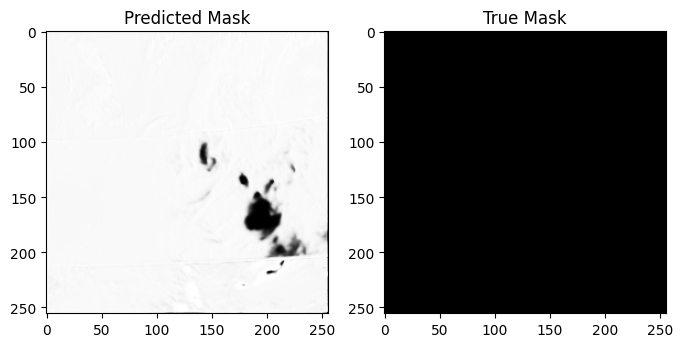

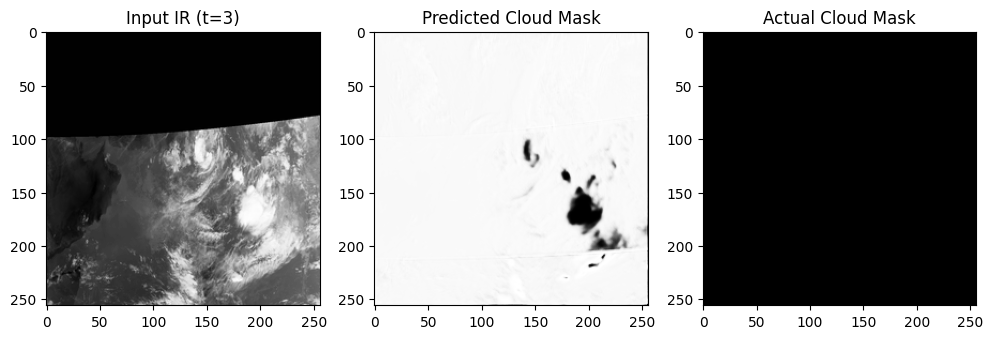

CSI (threshold=0.2): 0.986846923813067


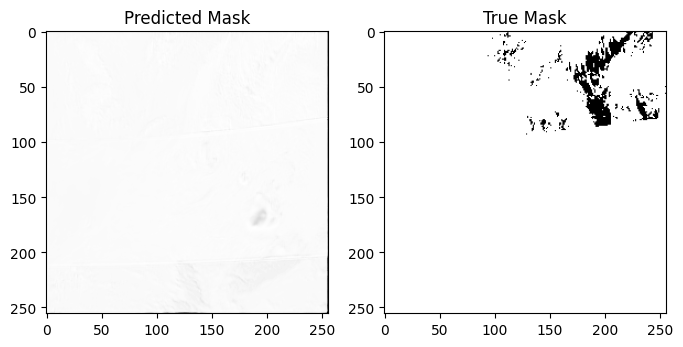

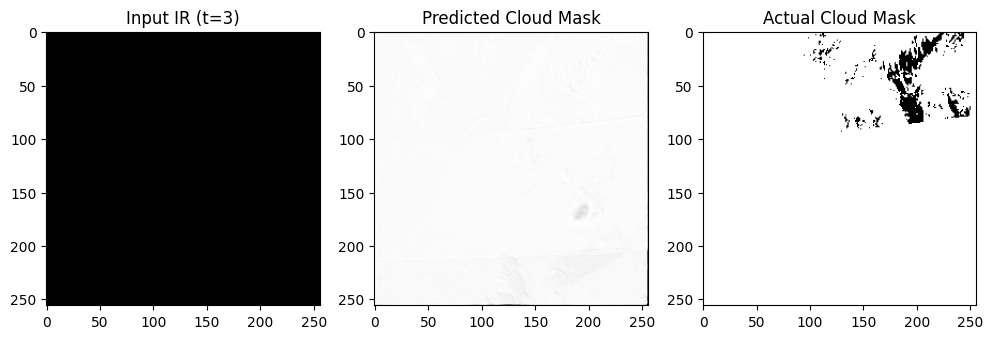

CSI (threshold=0.2): 0.9701843261570713


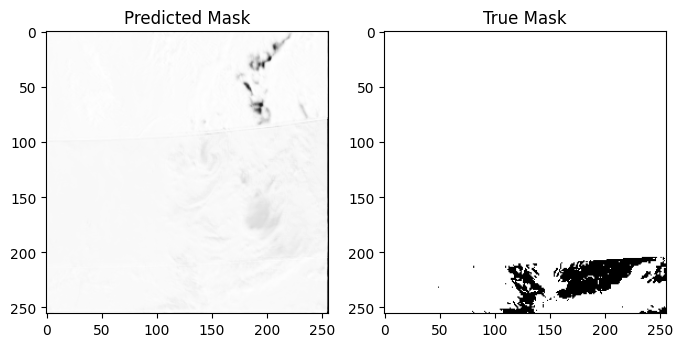

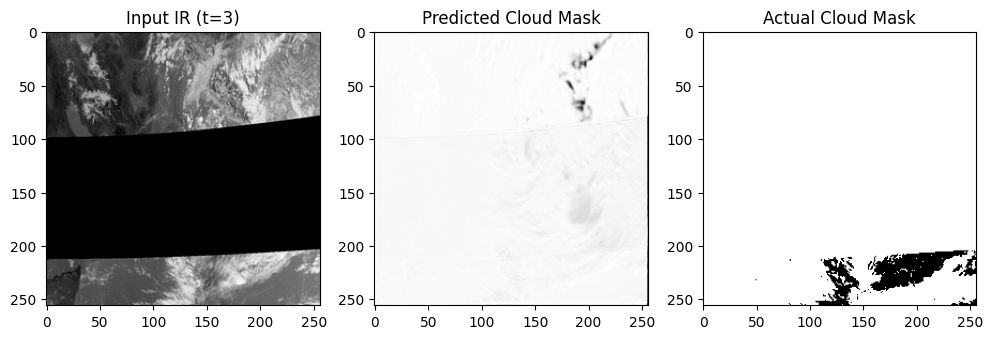

CSI (threshold=0.2): 0.957045853346196


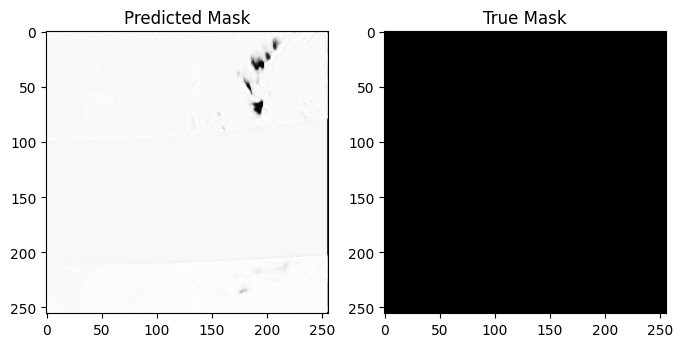

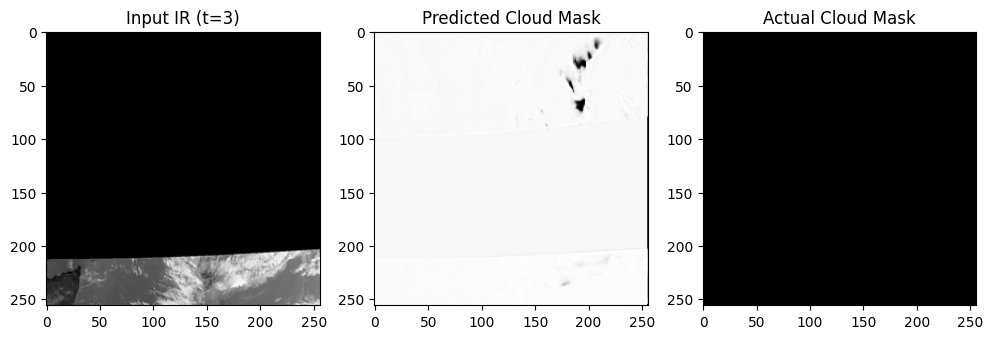

CSI (threshold=0.2): 0.9979553222503975


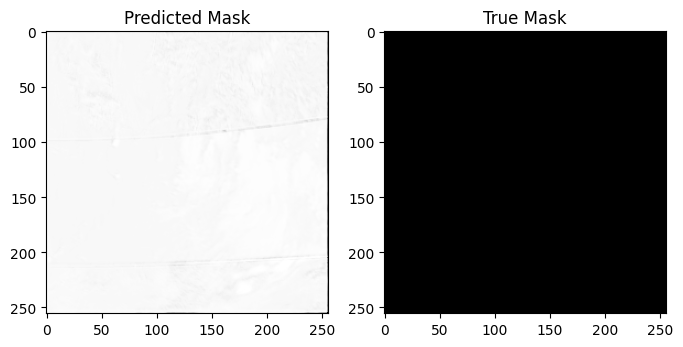

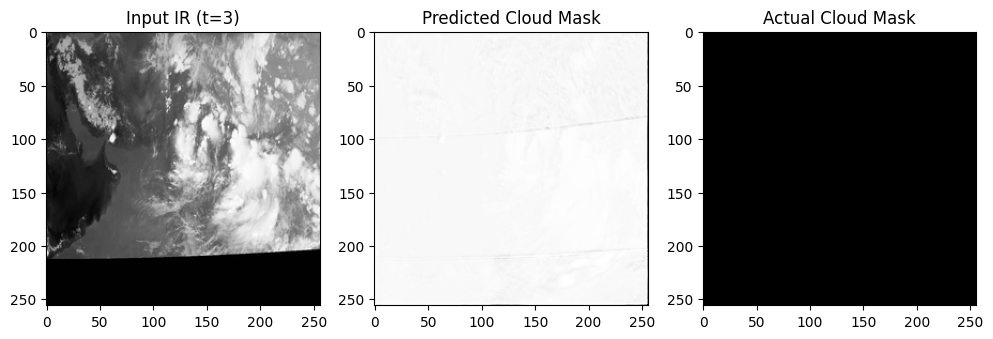

CSI (threshold=0.2): 0.9999694824066168


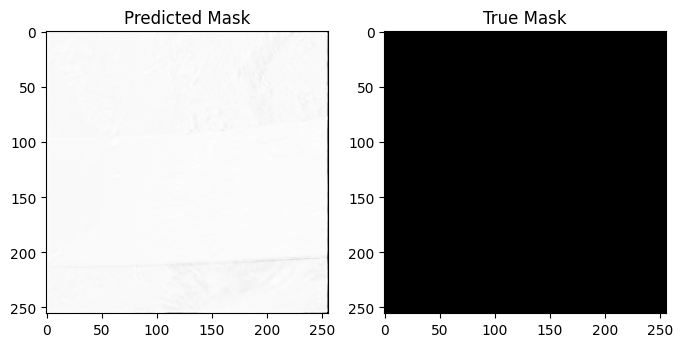

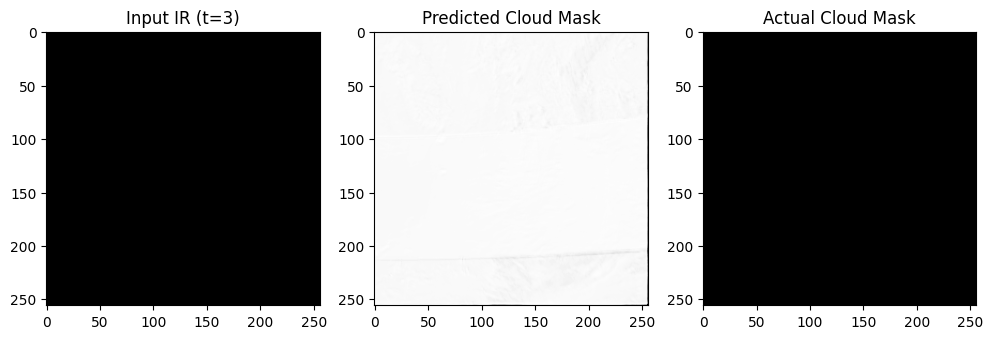

CSI (threshold=0.2): 0.9999694824066168


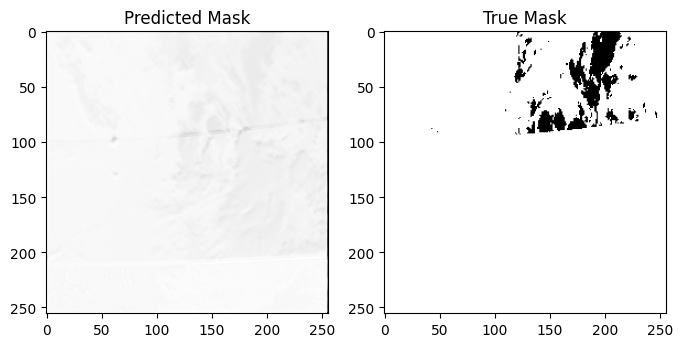

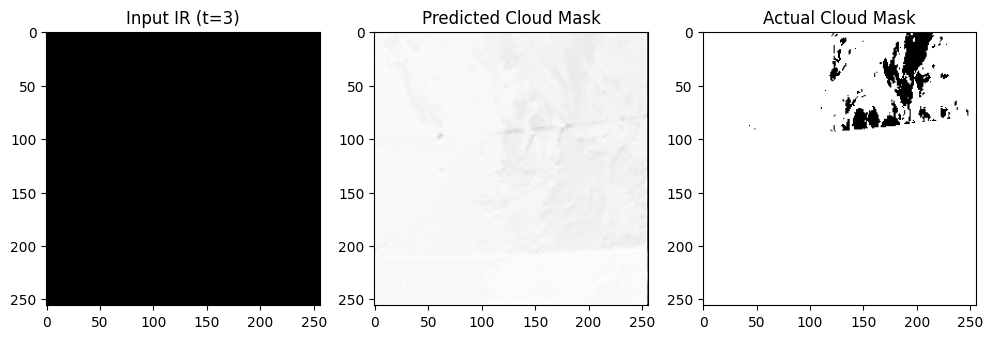

CSI (threshold=0.2): 0.9571533202978951


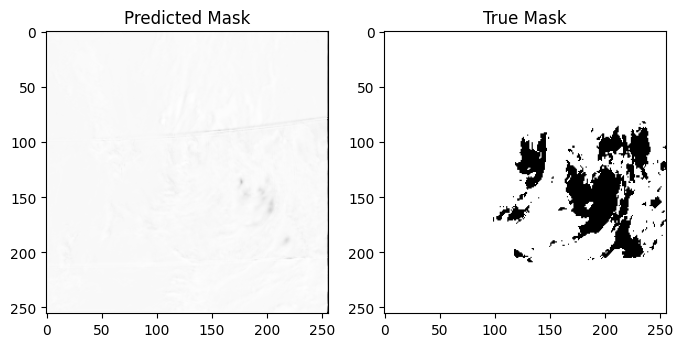

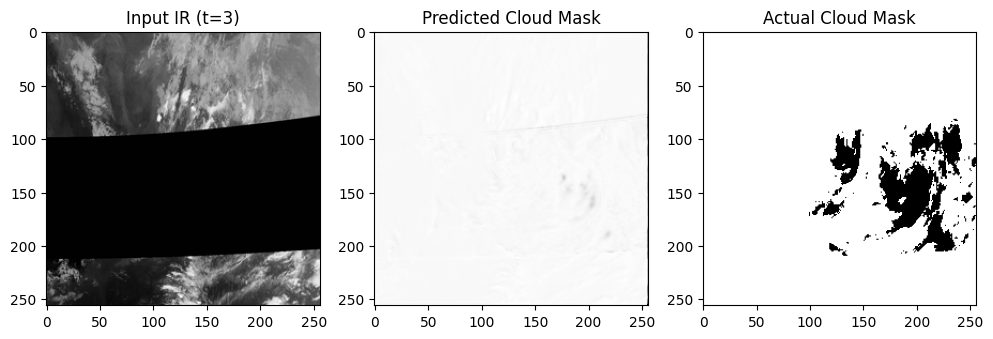

CSI (threshold=0.2): 0.9133758544782505


In [11]:
"""
Cloud Forecasting Pipeline (EUMETSAT, TensorFlow, July, 3hr→1hr)

This script builds and trains a cloud prediction model using all available EUMETSAT satellite data (IR and VIS channels) from the month of July.

Steps:
1. Imports & Setup
2. Data Loading & Sequence Extraction (all July days)
3. Cloud Mask Generation
4. Dataset Construction (train/val split)
5. Model Definition (ConvLSTM)
6. Training
7. Evaluation & Visualization
8. Export for Web Visualization
"""

# 1. Imports & Setup
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import urllib.parse

# 2. Data Loading & Sequence Extraction

def get_summer_folders(base_dir='downloaded_images'):
    # Find all folders for June and July (format: YYYY-MM-DD)
    folders = sorted([os.path.join(base_dir, d) for d in os.listdir(base_dir)
                     if os.path.isdir(os.path.join(base_dir, d)) and ('-06-' in d or '-07-' in d)])
    return folders

def extract_hour_from_filename(filename):
    # Decode URL-encoded characters
    decoded = urllib.parse.unquote(os.path.basename(filename))
    # Match pattern like [07-00] or [14-00]
    match = re.search(r'\[(\d{2})-\d{2}\]', decoded)
    if match:
        return int(match.group(1))
    return None

# Update list_hour_files to only include files with a valid hour

# Bands to use for robust all-day cloud detection
PRIMARY_BANDS = [
    ('IR_097', 'IR_097'),
    ('IR_134', 'IR_134'),
    ('WV_062', 'WV_062'),
]

# Flexible file matching for both June and July naming conventions

def list_hour_files(day_dir, band_name):
    files = []
    for f in os.listdir(day_dir):
        decoded = urllib.parse.unquote(f)
        if band_name in decoded and re.search(r'\[(\d{2})-\d{2}\]', decoded):
            files.append(os.path.join(day_dir, f))
    return sorted(files)

def extract_sequences_from_day(day_dir):
    # For each band, get files and build hour->file dict
    band_dicts = []
    for prefix, _ in PRIMARY_BANDS:
        files = list_hour_files(day_dir, prefix)
        band_dicts.append({extract_hour_from_filename(f): f for f in files})
    # Find hours present in all bands
    hours = sorted(list(set.intersection(*(set(d.keys()) for d in band_dicts))))
    sequences = []
    for i in range(len(hours) - 3):
        in_hours = hours[i:i+3]
        out_hour = hours[i+3]
        try:
            # For each band, get 3 input and 1 output files
            band_in = [[d[h] for h in in_hours] for d in band_dicts]
            band_out = [d[out_hour] for d in band_dicts]
            sequences.append({
                'band_in': band_in,  # list of [3 files] per band
                'band_out': band_out,  # list of 1 file per band
                'date': os.path.basename(day_dir),
                'in_hours': in_hours,
                'out_hour': out_hour
            })
        except KeyError:
            continue  # skip incomplete sequences
    return sequences

def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min() + 1e-6)

DOWNSAMPLED_SIZE = (256, 256)  # (width, height)
BATCH_SIZE = 8  # Increased batch size for faster training if RAM allows

def load_img(path):
    try:
        img = Image.open(path).convert('L')
        img = img.resize(DOWNSAMPLED_SIZE, resample=Image.LANCZOS)
        return normalize(np.array(img))
    except Exception as e:
        print(f"[ERROR] Could not load image: {path} ({e})")
        return None

# 3. Cloud Mask Generation

def cloud_mask(ir_img, vis_img, ir_thresh=0.6, vis_thresh=0.3):
    ir_mask = ir_img < ir_thresh
    vis_mask = vis_img > vis_thresh
    return ir_mask & vis_mask

# 4. Dataset Construction

def check_bands_in_folder(day_dir, required_bands):
    files = os.listdir(day_dir)
    present_bands = set()
    for file in files:
        for band in required_bands:
            if file.startswith(band):
                present_bands.add(band)
    missing = [band for band in required_bands if band not in present_bands]
    return missing

def build_dataset(summer_folders, val_days=3):
    all_sequences = []
    incomplete_days = []
    required_band_prefixes = [b[0] for b in PRIMARY_BANDS]
    for day_dir in summer_folders:
        missing = check_bands_in_folder(day_dir, required_band_prefixes)
        if missing:
            print(f"[WARNING] Skipping {os.path.basename(day_dir)}: missing bands {missing}")
            incomplete_days.append(os.path.basename(day_dir))
            continue
        all_sequences.extend(extract_sequences_from_day(day_dir))
    # Split by date for validation
    all_dates = sorted(list(set(seq['date'] for seq in all_sequences)))
    train_dates = all_dates[:-val_days]
    val_dates = all_dates[-val_days:]
    train_seqs = [seq for seq in all_sequences if seq['date'] in train_dates]
    val_seqs = [seq for seq in all_sequences if seq['date'] in val_dates]
    print(f"Total sequences: {len(all_sequences)} | Train: {len(train_seqs)} | Val: {len(val_seqs)}")
    if incomplete_days:
        print("Skipped days due to missing bands:", incomplete_days)
    return train_seqs, val_seqs

def seq_to_arrays(seq):
    band_in_imgs = []  # shape: [bands, 3, H, W]
    for band_files in seq['band_in']:
        imgs = [load_img(f) for f in band_files]
        if any(img is None for img in imgs):
            print(f"[WARNING] Skipping sequence due to unreadable input image(s): {band_files}")
            return None, None
        band_in_imgs.append(imgs)
    band_out_imgs = [load_img(f) for f in seq['band_out']]
    if any(img is None for img in band_out_imgs):
        print(f"[WARNING] Skipping sequence due to unreadable output image(s): {seq['band_out']}")
        return None, None
    X = np.stack([np.stack([band_in_imgs[b][t] for b in range(len(PRIMARY_BANDS))], axis=-1) for t in range(3)], axis=0)
    ir097_out = band_out_imgs[0]
    ir134_out = band_out_imgs[1]
    mask_ir097 = ir097_out < 0.6
    mask_ir134 = ir134_out < 0.6
    y = (mask_ir097 | mask_ir134).astype(np.float32)[..., np.newaxis]
    return X, y

def make_tf_dataset(sequences, batch_size=BATCH_SIZE, shuffle=True):
    def gen():
        idxs = list(range(len(sequences)))
        if shuffle:
            random.shuffle(idxs)
        for i in idxs:
            X, y = seq_to_arrays(sequences[i])
            if X is not None and y is not None:
                yield X, y
    sample_X, sample_y = None, None
    for seq in sequences:
        sample_X, sample_y = seq_to_arrays(seq)
        if sample_X is not None and sample_y is not None:
            break
    if sample_X is None or sample_y is None:
        raise RuntimeError("No valid sequences found for dataset!")
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=sample_X.shape, dtype=tf.float32),
            tf.TensorSpec(shape=sample_y.shape, dtype=tf.float32)
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=32)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# 5. Model Definition (ConvLSTM2D)

def dice_loss(y_true, y_pred):
    # Dice loss for binary segmentation
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def build_convlstm_satellite(input_shape):
    model = keras.Sequential([
        layers.ConvLSTM2D(16, (3,3), activation='relu', input_shape=input_shape, return_sequences=True, padding='same'),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(8, (3,3), activation='relu', return_sequences=False, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(1, (1,1), activation='sigmoid')
    ])
    # Use Dice loss for imbalanced segmentation
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
    return model

# 6. Training

def train_model(model, train_ds, val_ds, epochs=5):
    # Save the best model based on validation loss
    checkpoint_cb = ModelCheckpoint('cloud_forecast_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_cb])
    print("Best model saved as 'cloud_forecast_best_model.keras'")
    return history

# 7. Evaluation & Visualization

def plot_forecast(ir_img, y_pred, y_true):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(ir_img, cmap='gray')
    plt.title('Input IR (t=3)')
    plt.subplot(1,3,2)
    plt.imshow(y_pred, cmap='gray')
    plt.title('Predicted Cloud Mask')
    plt.subplot(1,3,3)
    plt.imshow(y_true, cmap='gray')
    plt.title('Actual Cloud Mask')
    plt.show()

def csi(y_true, y_pred, threshold=0.2):
    # Convert to numpy arrays if they are tensors
    if hasattr(y_true, 'numpy'):
        y_true = y_true.numpy()
    if hasattr(y_pred, 'numpy'):
        y_pred = y_pred.numpy()
    y_true = y_true > 0.5
    y_pred = y_pred > threshold
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fp + fn + 1e-6)

# 8. Export for Web Visualization

def export_forecast(y_pred, filename='forecast_cloud_mask.png'):
    Image.fromarray((y_pred*255).astype(np.uint8)).save(filename)

# =====================
# Main Pipeline Example
# =====================
if __name__ == "__main__":
    # 1. Find all June and July folders
    summer_folders = get_summer_folders('downloaded_images')
    print(f"Found {len(summer_folders)} June/July folders.")

    # 2. Build train/val sequence lists
    train_seqs, val_seqs = build_dataset(summer_folders, val_days=3)

    # 3. Build tf.data.Dataset objects
    train_ds = make_tf_dataset(train_seqs, batch_size=BATCH_SIZE, shuffle=True)
    val_ds = make_tf_dataset(val_seqs, batch_size=BATCH_SIZE, shuffle=False)

    # 4. Model
    # Use the shape of the first valid sample for input_shape
    sample_X, _ = None, None
    for seq in train_seqs:
        sample_X, _ = seq_to_arrays(seq)
        if sample_X is not None:
            break
    if sample_X is None:
        raise RuntimeError("No valid training sequences found for input shape!")
    input_shape = sample_X.shape  # (3, H, W, 3)
    model = build_convlstm_satellite(input_shape)
    model.summary()

    # 5. Train
    history = train_model(model, train_ds, val_ds, epochs=30)  # Increased epochs for deeper training

    # 6. Evaluate and visualize on a few validation samples
    for X, y in val_ds.take(1):
        y_pred = model.predict(X)
        # Print stats for debugging
        print('y_pred min:', y_pred.min(), 'max:', y_pred.max(), 'mean:', y_pred.mean())
        y_true_np = y[...,0].numpy() if hasattr(y[...,0], 'numpy') else y[...,0]
        print('y_true min:', y_true_np.min(), 'max:', y_true_np.max(), 'mean:', y_true_np.mean())
        # Visualize all predictions in the batch
        for i in range(X.shape[0]):
            plt.figure(figsize=(8,4))
            plt.subplot(1,2,1)
            plt.imshow(y_pred[i,...,0], cmap='gray')
            plt.title('Predicted Mask')
            plt.subplot(1,2,2)
            plt.imshow(y_true_np[i], cmap='gray')
            plt.title('True Mask')
            plt.show()
            plot_forecast(X[i,-1,:, :,0], y_pred[i,...,0], y[i,...,0])
            print(f'CSI (threshold=0.2):', csi(y[i,...,0], y_pred[i,...,0], threshold=0.2))

    # 7. Export one forecast
    export_forecast(y_pred[0,...,0]) 